In [1]:
import argparse, json, math, sys
from typing import Iterable, List, Optional
import pandas as pd
import numpy as np

In [18]:
SAMPLES_FILE_PATH = "/data/rasta/lm-evaluation-harness/results/Llama3.1_8B_v2_SFT_E2_remove_cot/__data__rasta__models__SFT__Llama-3.1-8B-Instruct_sft_LR2e-05_BS5_E2_DF0.8_remove_cot/samples_nutribench_v2_base_2025-08-26T22-20-27.778043.jsonl"
metrics = ['ae']

In [19]:
df = pd.read_json(SAMPLES_FILE_PATH, lines=True)
df[['filtered_resps', 'target']]

,filtered_resps,target
0,"[Answer: {""total_carbohydrates"": 93.99}]",90.80
1,"[Answer: {""total_carbohydrates"": 69.93}]",97.80
2,"[Answer: {""total_carbohydrates"": 31.55}]",51.20
3,"[Answer: {""total_carbohydrates"": 108.99}]",163.80
4,"[Answer: {""total_carbohydrates"": 86.11}]",81.10
...,...,...
15612,"[Answer: {""total_carbohydrates"": 32.34}]",40.79
15613,"[Answer: {""total_carbohydrates"": 98.73}]",42.05
15614,"[Answer: {""total_carbohydrates"": 25.21}]",7.89
15615,"[Answer: {""total_carbohydrates"": 59.29}]",39.68


In [20]:
print(df['arguments'][0]['gen_args_0']['arg_0'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a nutrition assistant that estimates carbohydrates from meal descriptions. For the given query including a meal description, respond with a dictionary object containing the total carbohydrates in grams as follows:
{"total_carbohydrates": total grams of carbohydrates for the serving}
Important:
- Only use the numeric amount of carbohydrates in the final dictionary, without extra text.
- Do **not** add extra text after the dictionary.

Follow the format of the following examples when answering-

Example 1:
Query: "This morning, I had a cup of oatmeal with half a sliced banana and a glass of orange juice."

Answer: {"total_carbohydrates": 66.5}

Example 2:
Query: "I ate scrambled eggs made with 2 eggs and a toast for breakfast."

Answer: {"total_carbohydrates": 15}

Example 3:
Query: "Half a peanut butter and jelly sandwich."

Answer: {"total_carbohydrates": 

In [21]:
df['filtered_resps'][0]

['Answer: {"total_carbohydrates": 93.99}']

In [22]:
df['filtered_resps'][:100]

0      [Answer: {"total_carbohydrates": 93.99}]
1      [Answer: {"total_carbohydrates": 69.93}]
2      [Answer: {"total_carbohydrates": 31.55}]
3     [Answer: {"total_carbohydrates": 108.99}]
4      [Answer: {"total_carbohydrates": 86.11}]
                        ...                    
95     [Answer: {"total_carbohydrates": 93.21}]
96    [Answer: {"total_carbohydrates": 163.10}]
97    [Answer: {"total_carbohydrates": 108.99}]
98    [Answer: {"total_carbohydrates": 124.84}]
99     [Answer: {"total_carbohydrates": 93.21}]
Name: filtered_resps, Length: 100, dtype: object

In [23]:
import ast, re, json, math
import numbers

def _parse_obj(val):
    """Helper: safely parse JSON-like objects/strings to Python objects."""
    if isinstance(val, (dict, list)):
        return val
    if isinstance(val, str):
        val = val.strip()
        # Try raw JSON parse
        try:
            return json.loads(val)
        except Exception:
            pass
        # Try to extract JSON substring inside text
        match = re.search(r"(\{.*?\}|\[.*?\])", val, flags=re.DOTALL)
        if match:
            try:
                return json.loads(match.group(1))
            except Exception:
                return None
    return None

def extract_carbs_strict(val):
    """
    Extract total_carbohydrates as a float from various representations:
      - dict: {"total_carbohydrates": 12.3}
      - list of dict(s): [{"total_carbohydrates": 12.3}, ...]
      - list of stringified dict(s): ['{"total_carbohydrates": 12.3}', ...]
    Rules:
      - Only accept real numeric values (ints/floats); strings are invalid.
      - NaN/None/invalid → return None.
    """
    # NaN/None handling up front
    if pd.isna(val):
        return None

    obj = _parse_obj(val)

    candidate = None
    if isinstance(obj, dict):
        candidate = obj
    elif isinstance(obj, list):
        for item in obj:
            parsed = _parse_obj(item)
            if isinstance(parsed, dict) and "total_carbohydrates" in parsed:
                candidate = parsed
                break
    else:
        return None

    if not isinstance(candidate, dict):
        return None

    tc = candidate.get("total_carbohydrates", None)

    if isinstance(tc, numbers.Real) and not isinstance(tc, bool):
        if isinstance(tc, float) and not math.isfinite(tc):
            return None
        return float(tc)

    # Everything else (strings, None, objects) is invalid
    return None

In [24]:
df['pred'] = df['filtered_resps'].apply(extract_carbs_strict)
df['pred']

0         93.99
1         69.93
2         31.55
3        108.99
4         86.11
          ...  
15612     32.34
15613     98.73
15614     25.21
15615     59.29
15616     36.78
Name: pred, Length: 15617, dtype: float64

In [25]:
extract_carbs_strict(df['filtered_resps'][0])

93.99

In [26]:
def get_metrics_from_samples(samples_jsonl_path: str) -> None:
    """
    Load values from a JSONL file and extract specified keys.
    Returns a list of values corresponding to the keys.
    """
    df = pd.read_json(samples_jsonl_path, lines=True)
    df['pred'] = df['filtered_resps'].apply(extract_carbs_strict)
    ratio = df["pred"].notna().sum() / len(df)
    print(f"Ratio of valid predictions: {ratio:.2%}")
    
    df["ae"] = (df["pred"] - df["target"]).abs()
    mae = df["ae"].mean(skipna=True)
    std = df["ae"].std(skipna=True)
    
    print(f"MAE: {mae:.4f} ± {std:.4f}")
    
    

In [27]:
get_metrics_from_samples(SAMPLES_FILE_PATH)

Ratio of valid predictions: 100.00%
MAE: 15.0502 ± 22.1552


In [28]:
print(df['filtered_resps'][0])

['Answer: {"total_carbohydrates": 93.99}']


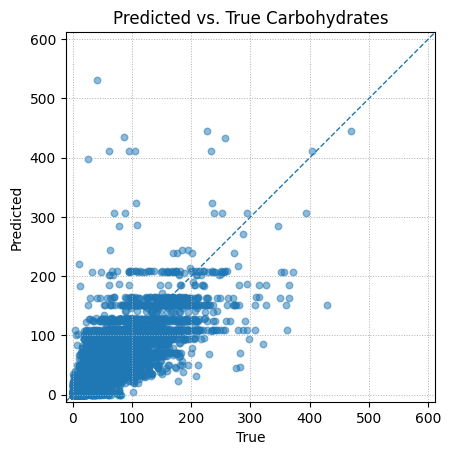

In [29]:
import matplotlib.pyplot as plt

def plot_pred_vs_true(df, y_true_col, y_pred_col, *, title=None, point_size=22, alpha=0.5):
    """
    Scatter plot of predicted vs. true values with a y=x reference line.
    Rows with NaN in either column are dropped.
    """
    # Coerce to numeric (in case the columns are strings) and drop NaNs in either column
    data = pd.DataFrame({
        "y_true": pd.to_numeric(df[y_true_col], errors="coerce"),
        "y_pred": pd.to_numeric(df[y_pred_col], errors="coerce"),
    }).dropna(subset=["y_true", "y_pred"])

    if data.empty:
        raise ValueError("No valid (true, pred) pairs after dropping NaNs.")

    x = data["y_true"].to_numpy()
    y = data["y_pred"].to_numpy()

    # Set up plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, s=point_size, alpha=alpha)

    # y = x line spanning the data range (with a small padding)
    # lo = np.min([x.min(), y.min()])
    # hi = np.max([x.max(), y.max()])
    lo = 0
    hi = 600
    pad = 0.02 * (hi - lo) if hi > lo else 1.0
    lo -= pad
    hi += pad

    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(title or f"Predicted vs. True ({y_pred_col} vs {y_true_col})")
    ax.grid(True, linestyle=":", linewidth=0.7)
    plt.show()
    

plot_pred_vs_true(df, "target", "pred", title="Predicted vs. True Carbohydrates")

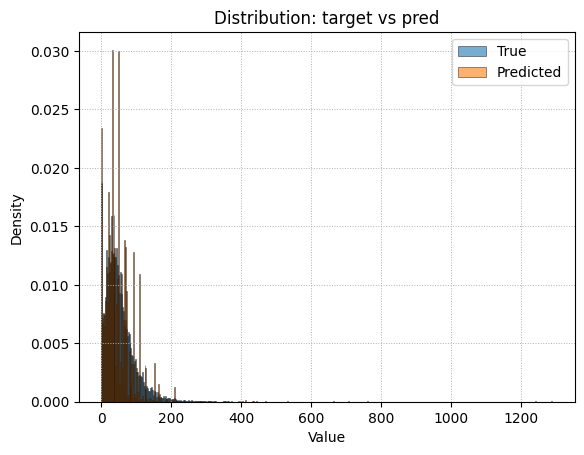

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_true_pred_hists(
    df,
    y_true_col,
    y_pred_col,
    *,
    bins="auto",          # int, sequence, or a rule like "auto", "fd", "sturges", ...
    density=True,         # True -> probability density; False -> counts
    layout="overlay",     # "overlay" or "side_by_side"
    title=None,
    range_=None           # optionally force (min, max) for both hists
):
    """
    Plot histograms for true and predicted values using identical bins.

    - NaNs in each column are ignored independently.
    - `layout="overlay"` draws both on the same axes with transparency.
      Use `layout="side_by_side"` for offset bars per bin.
    - `bins` can be an int, array-like bin edges, or a NumPy bin rule string.
    - `range_` (tuple) can clip both to the same (min, max).
    """
    # Coerce to numeric & drop NaNs independently
    true = pd.to_numeric(df[y_true_col], errors="coerce").dropna().to_numpy()
    pred = pd.to_numeric(df[y_pred_col], errors="coerce").dropna().to_numpy()

    if true.size == 0 and pred.size == 0:
        raise ValueError("No data in either column after dropping NaNs.")

    series = { "True": true, "Predicted": pred }
    series = {k: v for k, v in series.items() if v.size > 0}  # keep non-empty only

    # Determine common bin edges across whatever data exists
    if range_ is None:
        all_vals = np.concatenate(list(series.values()))
        bin_edges = np.histogram_bin_edges(all_vals, bins=bins)
    else:
        # If range is provided and bins is an int or rule, compute edges with that range
        if isinstance(bins, (int, str)):
            # Make temporary data spanning the range to get edges
            dummy = np.array(range_, dtype=float)
            bin_edges = np.histogram_bin_edges(dummy, bins=bins, range=range_)
        else:
            # bins already explicit edges; trust caller
            bin_edges = np.asarray(bins, dtype=float)

    fig, ax = plt.subplots()

    ylabel = "Density" if density else "Count"
    if layout == "overlay":
        # Overlaid histograms with shared edges
        for name, vals in series.items():
            ax.hist(vals, bins=bin_edges, density=density, alpha=0.6, label=name, edgecolor="black", linewidth=0.5)
    elif layout == "side_by_side":
        # Compute per-bin counts/densities and draw offset bars
        width = np.diff(bin_edges)
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        n_series = len(series)
        # bar width per series (leave small gap)
        bar_w = width / (n_series + 1.5)
        # offsets centered around each bin center
        offsets = (np.arange(n_series) - (n_series - 1) / 2) * bar_w

        for i, (name, vals) in enumerate(series.items()):
            counts, _ = np.histogram(vals, bins=bin_edges, density=density)
            ax.bar(centers + offsets[i], counts, width=bar_w, align="center", label=name, alpha=0.9)
    else:
        raise ValueError("layout must be 'overlay' or 'side_by_side'")

    ax.set_xlabel("Value")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"Distribution: {y_true_col} vs {y_pred_col}")
    ax.grid(True, linestyle=":", linewidth=0.7)
    ax.legend()
    plt.show()

# Examples:
# plot_true_pred_hists(df, "true", "pred", bins="fd", density=True, layout="overlay")
# plot_true_pred_hists(df, "true", "pred", bins=30, density=False, layout="side_by_side")

plot_true_pred_hists(df, "target", "pred", bins="fd", density=True, layout="overlay")

In [31]:
df['AE'] = (df['pred'] - df['target']).abs()

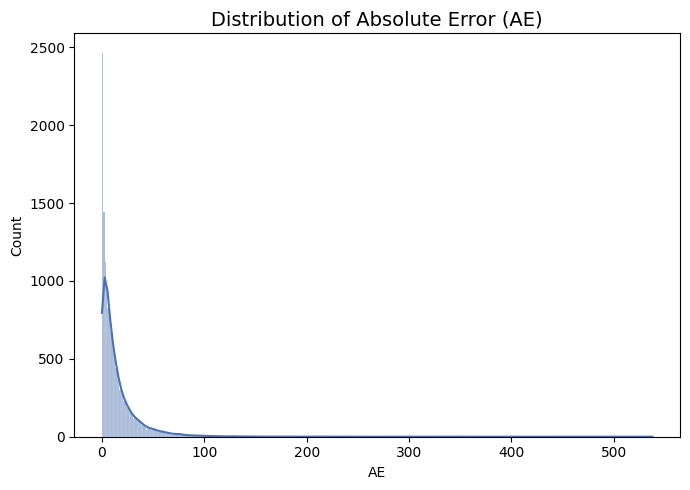

In [34]:
import seaborn as sns

# ae distribution
plt.figure(figsize=(7, 5))

# AE distribution
sns.histplot(df['AE'], kde=True, color="#4C72B0", edgecolor="white")
plt.title("Distribution of Absolute Error (AE)", fontsize=14)
plt.xlabel("AE")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [33]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
